## CHAPTER 2 EMBEDDINGS
Covers Simple Tokenization with regex, Tiktoken BPE, Token Embeddings and Positional Encoding

In [2]:
import urllib.request

In [3]:
url = ("https://raw.githubusercontent.com/rasbt/"
       "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
       "the-verdict.txt")

file_path = "the-verdict.txt"

In [4]:
urllib.request.urlretrieve(url, file_path)

('the-verdict.txt', <http.client.HTTPMessage at 0x7f18180df9d0>)

In [5]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text= f.read()

print("Total num of characters:", len(raw_text))
print(raw_text[:99])

Total num of characters: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


#### Simple Reg Expression Tokenization

In [6]:
import re
text = "Hello, world. This is a test."
result =  re.split(r'(\s)', text)
print(result)

['Hello,', ' ', 'world.', ' ', 'This', ' ', 'is', ' ', 'a', ' ', 'test.']


In [7]:
result =  re.split(r'([,.]|\s)', text)
print(result)

['Hello', ',', '', ' ', 'world', '.', '', ' ', 'This', ' ', 'is', ' ', 'a', ' ', 'test', '.', '']


In [8]:
text = "Hello, world. Is this-- a test?"
result = re.split(r'([,.:;?_!"()\']|--|\s)', text)
result = [item.strip() for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


In [9]:
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(len(preprocessed))
print(preprocessed[:30])

4690
['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


In [10]:
all_words = sorted(set(preprocessed))
vocab_size = len(all_words)
print(vocab_size)

1130


In [11]:
# Create Vocab

vocab = {token:integer for integer, token in enumerate(all_words)}

for i, item in enumerate(vocab.items()):
    print(item)
    if i >= 50:
        break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Chicago', 25)
('Claude', 26)
('Come', 27)
('Croft', 28)
('Destroyed', 29)
('Devonshire', 30)
('Don', 31)
('Dubarry', 32)
('Emperors', 33)
('Florence', 34)
('For', 35)
('Gallery', 36)
('Gideon', 37)
('Gisburn', 38)
('Gisburns', 39)
('Grafton', 40)
('Greek', 41)
('Grindle', 42)
('Grindles', 43)
('HAD', 44)
('Had', 45)
('Hang', 46)
('Has', 47)
('He', 48)
('Her', 49)
('Hermia', 50)


In [12]:
# Simple regular expression tokenizer

class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s, i in vocab.items()}

    def encode(self, text):
        # Splits on specified punctuations and whitespace
        # Removes whitespace.
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

In [13]:
tokenizer = SimpleTokenizerV1(vocab)
text = """"It's the last he painted, you know," 
            Mrs. Gisburn said with pardonable pride."""
ids = tokenizer.encode(text)
print(ids)

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]


In [14]:
print(tokenizer.decode(ids))

" It' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.


In [15]:
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])
vocab = {token:integer for integer, token in enumerate(all_tokens)}
print(len(vocab.items()))

for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)

1132
('younger', 1127)
('your', 1128)
('yourself', 1129)
('<|endoftext|>', 1130)
('<|unk|>', 1131)


In [16]:
# Simple regular expression tokenizer with unknown and end of text

class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s, i in vocab.items()}

    def encode(self, text):
        # Splits on specified punctuations and whitespace
        # Removes whitespace.
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [item if item in self.str_to_int else "<|unk|>" for item in preprocessed]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

In [17]:
text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."
text = " <|endoftext|> ".join((text1, text2))
print(text)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.


In [18]:
tokenizer = SimpleTokenizerV2(vocab)
print(tokenizer.encode(text))
print(tokenizer.decode(tokenizer.encode(text)))

[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]
<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.


#### Byte pair encoding

In [19]:
from importlib.metadata import version
import tiktoken
print("tiktoken version: ", version("tiktoken"))

tiktoken version:  0.9.0


In [20]:
tokenizer = tiktoken.get_encoding("gpt2")

In [21]:
text= (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
     "of someunknownPlace."
)

integers = tokenizer.encode(text, allowed_special= {"<|endoftext|>"})
print(integers)

strings = tokenizer.decode(integers)
print(strings)



[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 27271, 13]
Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.


In [22]:
ints = tokenizer.encode("Akwirw ier")
print(ints)

for i in ints:
    print(f"{i} - {tokenizer.decode([i])}")
strings = tokenizer.decode(ints)
print(strings)

[33901, 86, 343, 86, 220, 959]
33901 - Ak
86 - w
343 - ir
86 - w
220 -  
959 - ier
Akwirw ier


#### 2.6 Data sampling (creating input-target pairs with sliding window)

In [23]:
enc_text = tokenizer.encode(raw_text)
print(len(enc_text))
enc_sample = enc_text[50:]

5145


In [24]:
context_size = 4
x = enc_sample[:context_size]
y = enc_sample[1:context_size + 1]
print(f"x:  {x}")
print(f"y:      {y}")

x:  [290, 4920, 2241, 287]
y:      [4920, 2241, 287, 257]


In [25]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

 and ---->  established
 and established ---->  himself
 and established himself ---->  in
 and established himself in ---->  a


In [28]:
import torch
from torch.utils.data import Dataset, DataLoader


In [29]:
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []
        token_ids = tokenizer.encode(txt)

        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i : i + max_length]
            target_chunk = token_ids[i + 1 : i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
    
    def __len__(self):
        return(len(self.input_ids))
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [30]:
def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128,
                          shuffle=True, drop_last=True, num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    dataloader = DataLoader(
        dataset, 
        batch_size = batch_size, 
        shuffle = shuffle,
        drop_last = drop_last,
        num_workers = num_workers
        )
    
    return dataloader

In [31]:
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=4, stride=4, shuffle=False
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


#### 2.7 Embedding

In [32]:
input_ids = torch.tensor([2, 3, 5, 1])

vocab_size = 6
output_dim = 3

torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
print(embedding_layer.weight)

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


In [33]:
print(embedding_layer(torch.tensor([3])))
print(embedding_layer(input_ids))

tensor([[-0.4015,  0.9666, -1.1481]], grad_fn=<EmbeddingBackward0>)
tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


### 2.8 Positional

In [34]:
vocab_size = 50257  # bpe tiktoken vocab size
output_dim = 256    #model hidden dim
max_length = 4

token_embed_layer = torch.nn.Embedding(vocab_size, output_dim)
token_embeddings = token_embed_layer(inputs)
print(token_embeddings.shape)

# gpt learned positional
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)
pos_embeddings = pos_embedding_layer(torch.arange(context_length))
print(pos_embeddings.shape)

input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 256])
torch.Size([4, 256])
torch.Size([8, 4, 256])


## CHAPTER 3 ATTENTION

#### Simple Self Attention No weights

In [35]:
# Basic attention

inputs = torch.tensor(
    [[0.43, 0.15, 0.89], # Your (x^1)
    [0.55, 0.87, 0.66], # journey (x^2)
    [0.57, 0.85, 0.64], # starts (x^3)
    [0.22, 0.58, 0.33], # with (x^4)
    [0.77, 0.25, 0.10], # one (x^5)
    [0.05, 0.80, 0.55]] # step (x^6)
)

# Calculate attn score with query_2 as 2nd input

query_2 = inputs[1]
attn_scores_2 = torch.empty(inputs.shape[0])

for i, x_i in enumerate(inputs):
    attn_scores_2[i] = x_i @ query_2

print(attn_scores_2)

# Normalization using sum
attn_weights_2 = attn_scores_2 / attn_scores_2.sum()
print("\nAttention weights: ", attn_weights_2)
print("Sum: ", attn_weights_2.sum())

# Normalization using softmax

attn_weights_2 = torch.softmax(attn_scores_2, dim=0)
print("\nAttention weights: ", attn_weights_2)
print("Sum: ",  attn_weights_2.sum())

# context vector

context_vec_2 = torch.zeros(inputs.shape[1])

for i, x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i] * inputs[i]

print("\ncontext vector wrt to 2nd input", context_vec_2)


tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])

Attention weights:  tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum:  tensor(1.0000)

Attention weights:  tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum:  tensor(1.)

context vector wrt to 2nd input tensor([0.4419, 0.6515, 0.5683])


In [36]:
# Attention weights for every input

attn_scores = inputs @ inputs.T
print("\n attention scores \n", attn_scores)

attn_weights = torch.softmax(attn_scores, dim=1)
print("\n attention scores normalized \n", attn_weights)

print("\n attention weights sum \n", attn_weights.sum(dim=1))

all_context_vec = attn_weights @ inputs  # 6.6 @ 6.3
print("\n all context \n", all_context_vec)


 attention scores 
 tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])

 attention scores normalized 
 tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])

 attention weights sum 
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

 all context 
 tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.467

#### Simple self attention with trainable weights

In [37]:
x_2 = inputs[1]
d_in = inputs.shape[1]  # token embedding
d_out = 2   # att embedding

torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

query_2 = x_2 @ W_query
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value

print(query_2)


keys = inputs @ W_key
values = inputs @ W_value

print("keys.shape:", keys.shape)
print("values.shape:", values.shape)


attn_scores_2 = query_2 @ keys.T
print("\nAttention scores: ", attn_scores_2)

d_k = keys.shape[-1]
attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1)  # scale by sqrt(key_dim) and normalize softmax
print("Attention  weights: ", attn_weights_2)

context_vec_2 = attn_weights_2 @ values     # 1,6 @ 6, 2
print("context vector 2 ", context_vec_2)

tensor([0.4306, 1.4551])
keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])

Attention scores:  tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])
Attention  weights:  tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])
context vector 2  tensor([0.3061, 0.8210])


In [38]:
import torch.nn as nn

class SelfAttention_v1(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))
    
    def forward(self, x):
        keys = x @ self.W_key
        query = x @ self.W_query
        value = x @ self.W_value
        attn_scores = query @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[1] ** 0.5, dim = -1)
        
        context_vector = attn_weights @ value
        return context_vector


torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


In [39]:
class SelfAttention_v2(nn.Module):
    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        keys = self.W_key(x)
        query = self.W_query(x)
        value = self.W_value(x)
        attn_scores = query @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[1] ** 0.5, dim = -1)
        
        context_vector = attn_weights @ value
        return context_vector

torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


In [40]:
# Exercise 3.1
# Checking both implementations are same
sa_v1.W_query = nn.Parameter(sa_v2.W_query.weight.T)
sa_v1.W_key = nn.Parameter(sa_v2.W_key.weight.T)
sa_v1.W_value = nn.Parameter(sa_v2.W_value.weight.T)

print(sa_v1(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


In [41]:
# Causal Attention
queries = sa_v2.W_query(inputs)
keys = sa_v2.W_key(inputs)
attn_scores = queries @ keys.T
attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
print(attn_weights, "\n")

mask_simple = torch.tril(torch.ones_like(attn_scores))
print(mask_simple, "\n")

masked_simple = attn_weights * mask_simple
print(masked_simple, "\n")

row_sums = masked_simple.sum(dim=-1, keepdim=True)
masked_simple_norm = masked_simple / row_sums
print(masked_simple_norm)


tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>) 

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]]) 

tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<MulBackward0>) 

tensor([[1.0000, 0.0000, 

In [42]:
attn_scores = (attn_scores / keys.shape[-1]**0.5)
attn_scores = attn_scores.masked_fill(~(mask_simple.bool()), float('-inf'))
print(attn_scores)
attn_weights = torch.softmax(attn_scores, dim=-1)
print(attn_weights, "\n")

tensor([[0.2050,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.3293, 0.1218,   -inf,   -inf,   -inf,   -inf],
        [0.3249, 0.1204, 0.1224,   -inf,   -inf,   -inf],
        [0.1868, 0.0724, 0.0733, 0.0132,   -inf,   -inf],
        [0.1544, 0.0618, 0.0624, 0.0125, 0.0556,   -inf],
        [0.2410, 0.0898, 0.0912, 0.0140, 0.0912, 0.0055]],
       grad_fn=<MaskedFillBackward0>)
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>) 



In [43]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5)
example = torch.ones(6, 6)
print(dropout(example))

tensor([[2., 2., 2., 2., 2., 2.],
        [0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 2., 0.],
        [2., 2., 0., 0., 0., 2.],
        [2., 0., 0., 0., 0., 2.],
        [0., 2., 0., 0., 0., 0.]])


In [44]:
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape)

torch.Size([2, 6, 3])


In [45]:
class CausalAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            'mask',
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )
    
    def forward(self, x):
        b, num_tokens,  d_in = x.shape
        queries = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.transpose(1,2)
        attn_scores.masked_fill_(
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf
        )
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        attn_weights = self.dropout(attn_weights)
        context_vec = attn_weights @ values
        
        return context_vec

torch.manual_seed(123)
context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)
context_vecs = ca(batch)
print("context_vecs.shape:", context_vecs.shape)

context_vecs.shape: torch.Size([2, 6, 2])


In [46]:
class MultiHeadAttentionWrapper(nn.Module):
    def __init__(self, d_in, d_out, context_length,
                 dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
            [ CausalAttention(d_in, d_out, context_length, dropout, qkv_bias) 
                for _ in range(num_heads)
            ]
        )
    
    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)
    
torch.manual_seed(123)
context_length = batch.shape[1] # This is the number of tokens
d_in, d_out = 3, 2
mha = MultiHeadAttentionWrapper(d_in, d_out=1, context_length=context_length, dropout=0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[-0.5740,  0.2216],
         [-0.7320,  0.0155],
         [-0.7774, -0.0546],
         [-0.6979, -0.0817],
         [-0.6538, -0.0957],
         [-0.6424, -0.1065]],

        [[-0.5740,  0.2216],
         [-0.7320,  0.0155],
         [-0.7774, -0.0546],
         [-0.6979, -0.0817],
         [-0.6538, -0.0957],
         [-0.6424, -0.1065]]], grad_fn=<CatBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


In [47]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads) == 0, \
            "d_out must be divisible by num_heads"        
        
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )
        self.out_proj = nn.Linear(d_out, d_out)

    
    def forward(self, x):
        B, num_tokens, d_in = x.shape # shape of input (Batch, Sequence_length, Embedding_dim)
        keys = self.W_key(x)
        values = self.W_value(x)
        queries = self.W_query(x)

        # Split the dimensions across multiple heads effeciently
        keys = keys.view(B, num_tokens, self.num_heads, self.head_dim)
        values = values.view(B, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(B, num_tokens, self.num_heads, self.head_dim)

        # Change from (B, seq_length, num_heads, head_dim) -> (B, num_heads, seq_length, head_dim)
        keys = keys.transpose(1,2)
        values = values.transpose(1,2)
        queries = queries.transpose(1,2)

        attn_scores = values @ keys.transpose(2, 3)
        attn_scores.masked_fill_(
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf
        )
        attn_weights = torch.softmax(attn_scores / keys.shape[-1] ** 0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vector = (attn_weights @ values).transpose(1,2)

        context_vector = context_vector.contiguous().view(B, num_tokens, self.d_out)

        context_vector = self.out_proj(context_vector)

        return context_vector

In [48]:
torch.manual_seed(123)
batch_size, context_length, d_in = batch.shape
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[0.3190, 0.4858],
         [0.2950, 0.3853],
         [0.2861, 0.3556],
         [0.2701, 0.3840],
         [0.2644, 0.3890],
         [0.2584, 0.3999]],

        [[0.3190, 0.4858],
         [0.2950, 0.3853],
         [0.2861, 0.3556],
         [0.2701, 0.3840],
         [0.2644, 0.3890],
         [0.2584, 0.3999]]], grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


In [49]:
# Exercise 3.3 GPT-117 Mill params 12 att_head; d_in, d_out = 768 context = 1024

gpt_small = MultiHeadAttention(
    d_in = 768,
    d_out = 768,
    context_length = 1024,
    dropout = 0.5,
    num_heads = 12,
    qkv_bias = False
)

torch.manual_seed(123)
inputs = torch.rand((2,5,768))
out = gpt_small(inputs)
print(out.shape)


torch.Size([2, 5, 768])


## CHAPTER 4 FULL LLM GPT

In [50]:
# GPT-2 CONFIG

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,     # maximum number of input tokens the model can handle via the positional embeddings
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False       # not used in modern llms
}

In [51]:
class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        # Make a sequential list of transformer blocks
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))

        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)

        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)

        return logits



class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):
        return x
    


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()

    def forward(self, x):
        return x
    

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)


torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape: ", logits.shape)
print(logits)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Output shape:  torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


In [52]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

out = (out - mean) / torch.sqrt(var)

mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)

print("Normalized layer outputs:\n", out)
print("Mean:\n", mean)
print("Variance:\n", var)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)
Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)
Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [53]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift
    
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[-2.9802e-08],
        [ 0.0000e+00]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


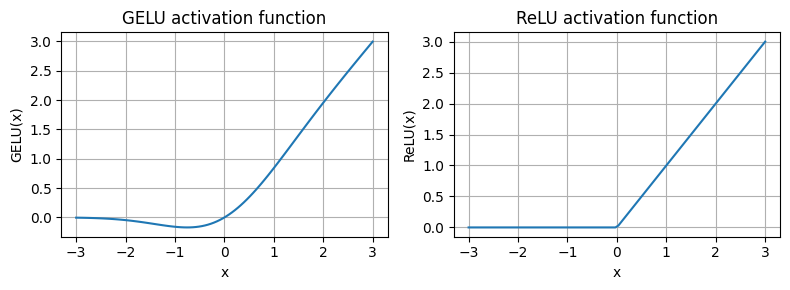

In [54]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))

import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

In [55]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)
    
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


In [56]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            dropout=cfg["drop_rate"],
            num_heads=cfg["n_heads"],
            qkv_bias=cfg["qkv_bias"])
        
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x

torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)
print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


In [57]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        # Make a sequential list of transformer blocks
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))

        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)

        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)

        return logits

In [58]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3668, -0.8859, -0.7218,  ..., -0.4649,  0.1406, -0.4010],
         [ 0.7476, -0.1745, -0.3436,  ...,  0.1874, -0.6372,  0.1068],
         [-0.3677,  0.2795, -0.3261,  ...,  1.1220,  0.4156, -0.5872]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.1388, -0.2333, -0.3451,  ...,  1.2001, -0.0114,  0.2768],
         [ 0.7228,  0.5585, -0.4454,  ...,  0.6902,  0.1729, -0.1896],
         [-0.1531, -0.0465,  0.4182,  ...,  1.2897, -0.4424,  0.0676]]],
       grad_fn=<UnsafeViewBackward0>)


In [59]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")


# More than 124m because of weight tying. not used in modern llms
total_params_gpt2 = (
    total_params - sum(p.numel() for p in model.out_head.parameters())
)
print(f"Number of trainable parameters "
      f"considering weight tying: {total_params_gpt2:,}"
)

total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")


Total number of parameters: 163,009,536
Number of trainable parameters considering weight tying: 124,412,160
Total size of the model: 621.83 MB


In [60]:
# Exercise 4.1
total_ff = 0
total_att = 0
for name, p in TransformerBlock(GPT_CONFIG_124M).named_parameters():
    if "att" in name:
        total_att += p.numel()
    elif 'ff' in name:
        total_ff += p.numel()

print(f"Number of params in feedforward modules: {total_ff:,}")
print(f"Number of params in attention modules: {total_att:,}")


Number of params in feedforward modules: 4,722,432
Number of params in attention modules: 2,360,064


In [61]:
# exercise 4.2
GPT_CONFIG_MED = {
    "vocab_size": 50257,
    "context_length": 1024,     # maximum number of input tokens the model can handle via the positional embeddings
    "emb_dim": 1024,
    "n_heads": 16,
    "n_layers": 24,
    "drop_rate": 0.1,
    "qkv_bias": False
}

GPT_CONFIG_LARGE = {
    "vocab_size": 50257,
    "context_length": 1024,     # maximum number of input tokens the model can handle via the positional embeddings
    "emb_dim": 1280,
    "n_heads": 20,
    "n_layers": 36,
    "drop_rate": 0.1,
    "qkv_bias": False
}

GPT_CONFIG_XL = {
    "vocab_size": 50257,
    "context_length": 1024,     # maximum number of input tokens the model can handle via the positional embeddings
    "emb_dim": 1600,
    "n_heads": 25,
    "n_layers": 48,
    "drop_rate": 0.1,
    "qkv_bias": False
}

configs = ["GPT_CONFIG_MED", "GPT_CONFIG_LARGE", "GPT_CONFIG_XL"]

def calculate_size(model):
    total_params = sum(p.numel() for p in model.parameters())
    total_size = (total_params * 4) / (1024 * 1024)

    print(f"Number of parameters in model is {total_params:,}")
    print(f"Total size of the model: {total_size:.2f} MB\n")

for config in configs:
    print("Inititlazing", config)
    model_test = GPTModel(globals()[config])
    calculate_size(model_test)
    del(model_test)

Inititlazing GPT_CONFIG_MED
Number of parameters in model is 406,212,608
Total size of the model: 1549.58 MB

Inititlazing GPT_CONFIG_LARGE
Number of parameters in model is 838,220,800
Total size of the model: 3197.56 MB

Inititlazing GPT_CONFIG_XL
Number of parameters in model is 1,637,792,000
Total size of the model: 6247.68 MB



In [62]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        
        logits = logits[:, -1, :]     # Logit goes from (batch_size, seq_len, vocab_size) -> (batch, vocab_size)
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=-1)
    
    return idx

start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

model.eval()
out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output:", out)
print("Output length:", len(out[0]))
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])
Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 49419, 35254]])
Output length: 10
Hello, I am Featureiman Byeswick lug brightly


## CHAPTER 5 TRAINING

In [63]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids =generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))



Output text:
 Every effort moves you rentingetic minion mobilized Macicone warrantyuler respirmediated


In [64]:
inputs = torch.tensor([[16833, 3626, 6100],     # ["every effort moves",
                       [40, 1107, 588]])     # "I really like"]

targets = torch.tensor([[3626, 6100, 345 ], # [" effort moves you",
                        [1107, 588, 11311]]) # " really like chocolate"]

with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1)
print(probas.shape)

token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1:"
      f" {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")


text_idx = 0
target_probas_1 = probas[text_idx, [0,1,2], targets[text_idx]]
print("Text 1: ", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(f"\n{log_probas}")

neg_avg_log_probas = torch.mean(log_probas) * -1
print(neg_avg_log_probas)

torch.Size([2, 3, 50257])
Token IDs:
 tensor([[[16657],
         [16031],
         [42826]],

        [[49906],
         [29669],
         [25338]]])
Targets batch 1:  effort moves you
Outputs batch 1:  Armed savesNetflix
Text 1:  tensor([7.4540e-05, 2.8347e-05, 1.2747e-05])
Text 2: tensor([1.0337e-05, 5.3510e-05, 5.6681e-06])

tensor([ -9.5042, -10.4710, -11.2702, -11.4798,  -9.8356, -12.0807])
tensor(10.7736)


In [65]:
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

logits_flat = logits.flatten(0,1)
target_flat = targets.flatten()
print(logits_flat.shape)
print(target_flat.shape)

loss = nn.functional.cross_entropy(logits_flat, target_flat)
print(loss)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])
torch.Size([6, 50257])
torch.Size([6])
tensor(10.7736)


In [66]:
#perplexity

ppl = torch.exp(loss)
print("Perplexity: ", ppl)

Perplexity:  tensor(47742.5195)


In [67]:
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as f:
    text_data = f.read()

total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters: ", total_characters)
print("Tokens: ", total_tokens)

Characters:  20479
Tokens:  5145


In [68]:
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [69]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0,1), target_batch.flatten()
    )
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    
    if len(data_loader) == 0: 
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)
print("Training Loss: ", train_loss)
print("Val Loss: ", val_loss)    


DeferredCudaCallError: CUDA call failed lazily at initialization with error: device >= 0 && device < num_gpus INTERNAL ASSERT FAILED at "/pytorch/aten/src/ATen/cuda/CUDAContext.cpp":49, please report a bug to PyTorch. device=1, num_gpus=

CUDA call was originally invoked at:

  File "/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 205, in start
    self.asyncio_loop.run_forever()
  File "/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
    self._run_once()
  File "/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
    handle._run()
  File "/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
    await self.process_one()
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 534, in process_one
    await dispatch(*args)
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
    await result
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
    await super().execute_request(stream, ident, parent)
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
    reply_content = await reply_content
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
    res = shell.run_cell(
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
    return super().run_cell(*args, **kwargs)
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell
    result = self._run_cell(
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell
    result = runner(coro)
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2211643/1720635655.py", line 1, in <module>
    import torch.nn as nn
  File "<frozen importlib._bootstrap>", line 1007, in _find_and_load
  File "<frozen importlib._bootstrap>", line 972, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 1007, in _find_and_load
  File "<frozen importlib._bootstrap>", line 986, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 680, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/torch/__init__.py", line 2046, in <module>
    _C._initExtension(_manager_path())
  File "<frozen importlib._bootstrap>", line 1007, in _find_and_load
  File "<frozen importlib._bootstrap>", line 986, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 680, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/torch/cuda/__init__.py", line 264, in <module>
    _lazy_call(_check_capability)
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/torch/cuda/__init__.py", line 261, in _lazy_call
    _queued_calls.append((callable, traceback.format_stack()))


In [74]:
import torch

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model.to(device)

Using device: cuda


DeferredCudaCallError: CUDA call failed lazily at initialization with error: device >= 0 && device < num_gpus INTERNAL ASSERT FAILED at "/pytorch/aten/src/ATen/cuda/CUDAContext.cpp":49, please report a bug to PyTorch. device=1, num_gpus=

CUDA call was originally invoked at:

  File "/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 205, in start
    self.asyncio_loop.run_forever()
  File "/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
    self._run_once()
  File "/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
    handle._run()
  File "/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
    await self.process_one()
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 534, in process_one
    await dispatch(*args)
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
    await result
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
    await super().execute_request(stream, ident, parent)
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
    reply_content = await reply_content
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
    res = shell.run_cell(
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
    return super().run_cell(*args, **kwargs)
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell
    result = self._run_cell(
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell
    result = runner(coro)
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2211643/1720635655.py", line 1, in <module>
    import torch.nn as nn
  File "<frozen importlib._bootstrap>", line 1007, in _find_and_load
  File "<frozen importlib._bootstrap>", line 972, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 1007, in _find_and_load
  File "<frozen importlib._bootstrap>", line 986, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 680, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/torch/__init__.py", line 2046, in <module>
    _C._initExtension(_manager_path())
  File "<frozen importlib._bootstrap>", line 1007, in _find_and_load
  File "<frozen importlib._bootstrap>", line 986, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 680, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/torch/cuda/__init__.py", line 264, in <module>
    _lazy_call(_check_capability)
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/torch/cuda/__init__.py", line 261, in _lazy_call
    _queued_calls.append((callable, traceback.format_stack()))


In [78]:
if torch.cuda.is_available():

    print("CUDA is available")

    print("Number of GPUs:", torch.cuda.device_count())

else:

    print("CUDA is not available")

CUDA is available
Number of GPUs: 4


In [76]:
x = torch.randn((1, 5), device=device)

DeferredCudaCallError: CUDA call failed lazily at initialization with error: device >= 0 && device < num_gpus INTERNAL ASSERT FAILED at "/pytorch/aten/src/ATen/cuda/CUDAContext.cpp":49, please report a bug to PyTorch. device=1, num_gpus=

CUDA call was originally invoked at:

  File "/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 205, in start
    self.asyncio_loop.run_forever()
  File "/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
    self._run_once()
  File "/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
    handle._run()
  File "/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
    await self.process_one()
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 534, in process_one
    await dispatch(*args)
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
    await result
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
    await super().execute_request(stream, ident, parent)
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
    reply_content = await reply_content
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
    res = shell.run_cell(
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
    return super().run_cell(*args, **kwargs)
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell
    result = self._run_cell(
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell
    result = runner(coro)
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2211643/1720635655.py", line 1, in <module>
    import torch.nn as nn
  File "<frozen importlib._bootstrap>", line 1007, in _find_and_load
  File "<frozen importlib._bootstrap>", line 972, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 1007, in _find_and_load
  File "<frozen importlib._bootstrap>", line 986, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 680, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/torch/__init__.py", line 2046, in <module>
    _C._initExtension(_manager_path())
  File "<frozen importlib._bootstrap>", line 1007, in _find_and_load
  File "<frozen importlib._bootstrap>", line 986, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 680, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/torch/cuda/__init__.py", line 264, in <module>
    _lazy_call(_check_capability)
  File "/home/joluseti/projects/gpt-scratch/.venv/lib/python3.9/site-packages/torch/cuda/__init__.py", line 261, in _lazy_call
    _queued_calls.append((callable, traceback.format_stack()))


In [ ]:
## train loop

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, 
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_token_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_token_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}"
                )
            generate_text_simple(model, tokenizer, device, start_context)
    
    return train_losses, val_losses, track_token_seen

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
        train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
        val_loader, model, device, num_batches=eval_iter
        )
    model.train()
    return train_loss, val_loss